# LINMA2222 - Stochastic Optimal Control & Reinforcement Learning
## Portfolio optimal strategy
---

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)  # For reproducibility

### Constants

In [2]:
THETA = 0.5
W_A = 0.1
W_U = 0.2
SIGMA_A = 0.018
SIGMA_P = 0.02
BETA_U = -0.048
GAMMA_U = 0.06

### Plot functions

In [3]:

from tqdm import tqdm
def generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=1, xi_a=None, xi_p=None, show_progress=False):
    """Generate the state variables x_t and actions u_t for t=0,...,T
       using the given policy.

    Args:
        policy: a function that takes in the current state x_t and returns an action u_t
        x0 (ndarray): initial state. Defaults to 0.
        T (int): number of time steps. Defaults to 1000.
    """
    x = np.zeros((T+1, 3, N))  # State variables: q_t, za_t, zu_t
    u = np.zeros((T, N))       # Actions
    x[0] = np.array(x0).reshape(3, 1)
    if xi_a is None:  xi_a = rng.normal(0, 1, size=(T, N))
    if xi_p is None:  xi_p = rng.normal(0, 1, size=(T, N))


    r = range(T) if not show_progress else tqdm(range(T), desc="Generating trajectories")
    for t in r:
        u[t] = policy(x[t])
        x[t+1, 0] = x[t, 0] + u[t] # q_t
        x[t+1, 1] = (1 - W_A) * x[t, 1] + W_A * SIGMA_A * xi_a[t]  # za_t
        x[t+1, 2] = (1 - W_U) * x[t, 2] + W_U * BETA_U * u[t]  # zu_t

    return x, u, xi_p


def g(q, za, zu , u, xi_p=None):
    """Compute the gross stage reward at each time given state x and action u."""
    # q, za, zu = x[:, 0], x[:, 1], x[:, 2]
    if xi_p is None:
        xi_p = rng.normal(0, 1, size=q.shape[0])

    # Formula found by replacing p_t+1 and p_t by their expressions in the given model (see Question 2.3)
    return 1000 * q * (za + zu + (GAMMA_U * u) + (SIGMA_P * xi_p)) + THETA * u * (za + zu + (SIGMA_P * xi_p))


def c(g):   
    """Compute the net stage reward given gross stage reward g_t for each time t"""
    return np.maximum(g - (np.pow(g, 2) / 2), 1 - np.exp(-g))

def reward(x, u, xi_p, t):
    """Compute all the rewards over the trajectory given states x and actions u from time 0 to t."""
    """returns an array of shape (t,N)"""
    g_t = g(x[:t, 0], x[:t, 1], x[:t, 2], u[:t], xi_p=xi_p[:t])
    c_t = c(g_t)
    return c_t

def average_reward(x, u, xi_p, t):
    return np.nanmean(reward(x, u, xi_p, t))


def plot_trajectories(x, u, xi_p, filename=None, mean=False, variance=False, T=None):
    """Plot the trajectories of the state variables and actions over time in a 2x2 grid
       and add an additional plot for the average reward as a function of time."""
    if T is None:
        T = x.shape[0] - 1
    print(f"Plotting {filename} : reward = {average_reward(x, u, xi_p, T)}")
    
    time = np.arange(T+1)

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].plot(time, x[:, 0], label=r'$q_t$', color='blue')
    if mean:
        axs[0, 0].hlines(np.nanmean(x[:, 0]), 0, T, colors='darkblue', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 0].fill_between(time, np.nanmean(x[:, 0]) - np.std(x[:, 0]), np.nanmean(x[:, 0]) + np.std(x[:, 0]), color='cyan', alpha=0.3, label='Variance')
    axs[0, 0].set_title(r'$q_t$')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel(r'$q_t$')
    axs[0, 0].grid()
    axs[0, 0].legend()

    axs[0, 1].plot(time, x[:, 1], label=r'$z^{a}_{t}$', color='orange')
    if mean:
        axs[0, 1].hlines(np.nanmean(x[:, 1]), 0, T, colors='darkorange', linestyles='dashed', label='Mean')
    if variance:
        axs[0, 1].fill_between(time, np.nanmean(x[:, 1]) - np.std(x[:, 1]), np.nanmean(x[:, 1]) + np.std(x[:, 1]), color='moccasin', alpha=1, label='Variance')
    axs[0, 1].set_title(r'$z^{a}_{t}$')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel(r'$z^{a}_{t}$')
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(time, x[:, 2], label=r'$z^{u}_{t}$', color='green')
    if mean:
        axs[1, 0].hlines(np.nanmean(x[:, 2]), 0, T, colors='darkgreen', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 0].fill_between(time, np.nanmean(x[:, 2]) - np.std(x[:, 2]), np.nanmean(x[:, 2]) + np.std(x[:, 2]), color='lightgreen', alpha=1, label='Variance')
    axs[1, 0].set_title(r'$z^{u}_{t}$')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel(r'$z^{u}_{t}$')
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(time[:-1], u, label=r'$u_{t}$', color='red')
    if mean:
        axs[1, 1].hlines(np.nanmean(u), 0, T-1, colors='darkred', linestyles='dashed', label='Mean')
    if variance:
        axs[1, 1].fill_between(time[:-1], np.nanmean(u) - np.std(u), np.nanmean(u) + np.std(u), color='lightcoral', alpha=1, label='Variance')
    axs[1, 1].set_title(r'$u_{t}$')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel(r'$u_{t}$')
    axs[1, 1].grid()
    axs[1, 1].legend()

    # plt.tight_layout()
    if filename:
        plt.savefig("figures/" + filename + "_states_actions.svg", format='svg')
    plt.show()

    # plot_average_reward(x, u, xi_p, T=T, filename=filename)







def plot_average_reward(x, u, xi_p, T=1000, filename=None):
    # Plot average reward as a function of time
    avg_rewards = [np.nanmean(reward(x, u, xi_p, t)) for t in range(1, T+1)]
    
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(1, T+1), avg_rewards, label='Average Reward', color='purple')
    plt.title('Average Reward Over Time')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid()

    plt.legend()
    if filename:
        plt.savefig("figures/" + filename + "_average_reward.svg", format='svg')
    plt.show()



### Question 3.1

$\pi_{cl}(x_t) = K_{cl} x_t$


Plotting question_3_1_1_unclipped : reward = 0.012384123563058423


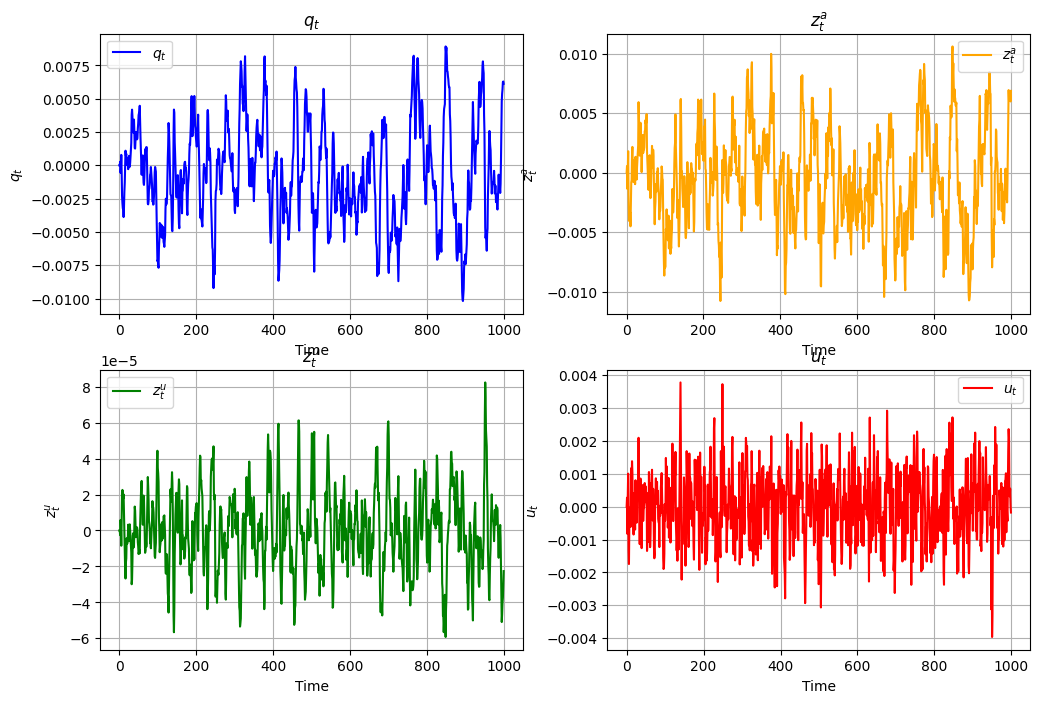

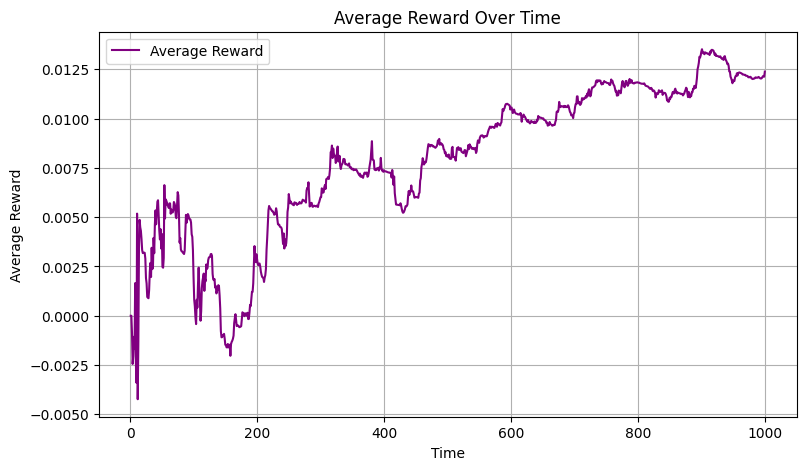

Plotting question_3_1_1_clipped : reward = 0.008817871576103642


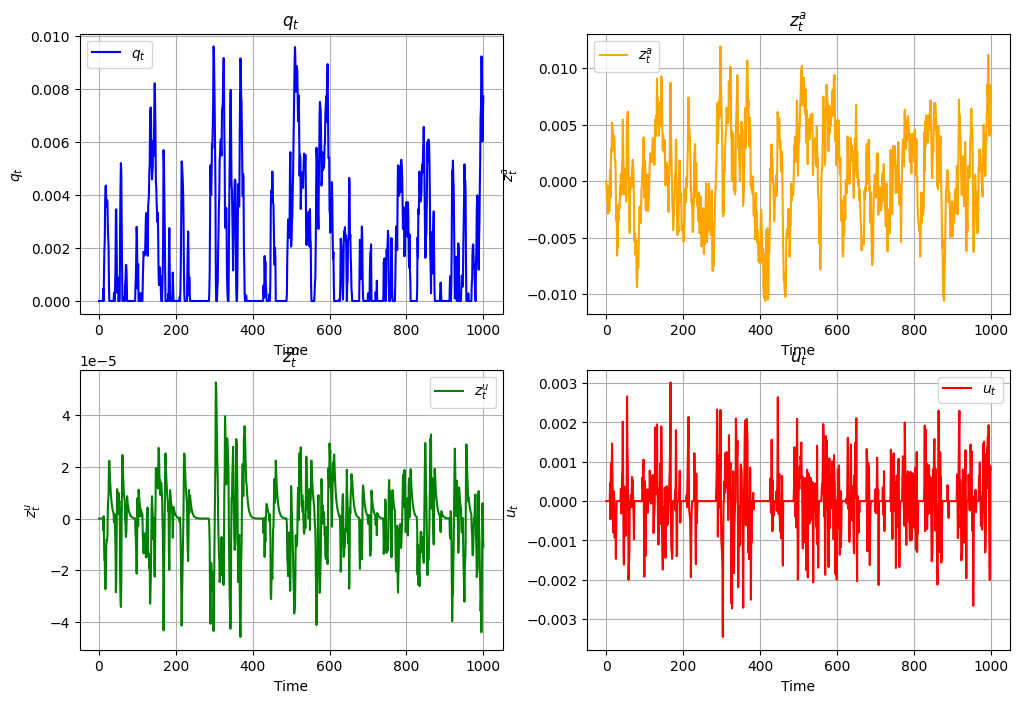

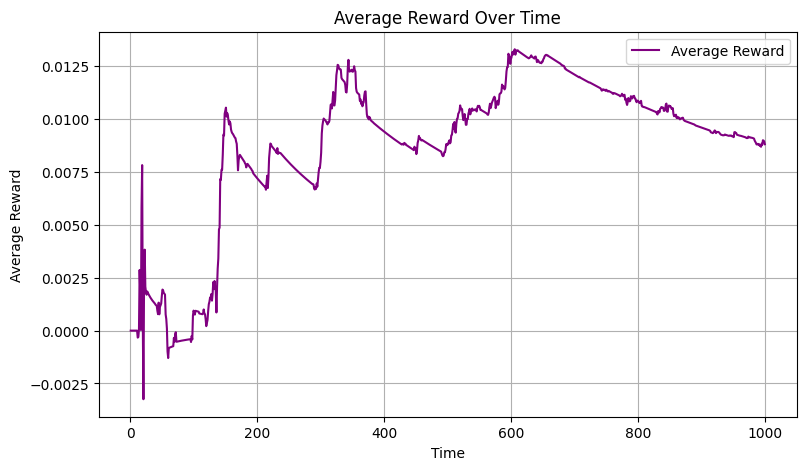

In [4]:
rng = np.random.default_rng(42)  # For reproducibility

# Question 3.1.1
policy = lambda x: -0.5 * x[0] + 0.5 * x[1] + 0.5 * x[2]
cliped_policy = lambda x: np.clip(policy(x), -x[0], 1-x[0])
random_policy = lambda x: rng.uniform(-x[0] * 0.1, (1 - x[0]) * 0.1)

x, u, xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_1_1_unclipped")
plot_average_reward(x, u, xi_p, filename="question_3_1_1_unclipped")

x, u, xi_p = generate_trajectories(cliped_policy, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_1_1_clipped")
plot_average_reward(x, u, xi_p, filename="question_3_1_1_clipped")

# x, u, xi_p = generate_trajectories(random_policy, x0=(0, 0, 0), T=1000)
# plot_trajectories(x, u, xi_p, filename="question_3_1_1_random")
# plot_average_reward(x, u, xi_p, filename="question_3_1_1_random")

policy_list = [(policy, "Initial Policy"), (cliped_policy, "Clipped Initial Policy")]



In [5]:
### simulate trajectories and plot the average reward over time

rng = np.random.default_rng(42)  # For reproducibility

# Question 3.1.2
S = 1000
def run_trajectories(policy, N=1000, name="policy", show_all=False, T=1000, show_progress=False):
    """Run N trajectories using the given policy and plot the average reward over time."""
    if show_all:
        all_x = np.zeros(( T+1, 3, N))
        all_u = np.zeros((T, N))
        all_xi_p = np.zeros((T, N))

    all_rewards = np.zeros((T, N))

    # for i in range(N):
    #     x, u, xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=T)
    #     if show_all:
    #         all_x[i] = x
    #         all_u[i] = u
    #         all_xi_p[i] = xi_p
    #     all_rewards[i] = reward(x, u, xi_p, T)

    all_x, all_u, all_xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=T, N=N, show_progress=show_progress)
    all_rewards = reward(all_x[:, :, :], all_u[:, :], all_xi_p[:, :], T).T

    reward_mean = np.nanmean(all_rewards, axis=0) # average reward for each time step
    # skip nan values
    print(f"Average reward of {name} over {N} trajectories: {np.nanmean(all_rewards)} and std: {np.std(all_rewards)}")


    ### Cumulative reward
    plt.figure(figsize=(9, 5))
    # for i in range(N):
    #     plt.plot(np.arange(1, T+1), np.cumsum(all_rewards[i]) / (np.arange(1, T+1)), color='gray', alpha=0.05)
    # plt.plot(np.arange(1, T+1), np.cumsum(reward_mean) / (np.arange(1, T+1)), label='Average Reward', color='purple')

    # just the reward
    for i in range(N):
        plt.plot(np.arange(1, T+1), all_rewards[i], color='gray', alpha=0.05)
    plt.plot(np.arange(1, T+1), reward_mean, label='Average Reward', color='purple')
    plt.title(f'Average Reward by time of {name} Over {N} trajectories')
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid()
    # Save cumulative reward plot
    filename_safe = name.replace(" ", "_").lower()
    plt.savefig(f"figures/{filename_safe}_cumulative_reward_{N}_trajectories.svg", format='svg')
    plt.show()


    ### show the reward distribution
    plt.figure(figsize=(9, 5))
    plt.hist(np.nanmean(all_rewards, axis=1), bins=50, color='purple', alpha=0.7, density=True)
    # max_reward = np.max(all_rewards, axis=1)
    # all_rewards[:, -1]
    reward_final_mean = np.nanmean(all_rewards)
    reward_final_var = np.var(all_rewards)
    plt.text(0.02, 0.98, f'Mean: {reward_final_mean:.2e}\nVar: {reward_final_var:.2e}', transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # show the mean as a dashed line
    plt.axvline(reward_final_mean, color='darkviolet', linestyle='dashed', label='Mean')
    plt.legend()

    plt.title(f'Average Reward Distribution of {name} Over {N} trajectories')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.grid()
    # Save final reward distribution plot
    plt.savefig(f"figures/{filename_safe}_final_reward_distribution_{N}_trajectories.svg", format='svg')
    plt.show()


    if show_all:
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        for i in range(N):
            plt.plot(np.arange(T+1), all_x[:, 0, i], color='blue', alpha=0.05)
        plt.title(r'$q_t$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$q_t$')
        plt.grid()
        plt.subplot(3, 1, 2)
        for i in range(N):
            plt.plot(np.arange(T+1), all_x[:, 1, i], color='orange', alpha=0.05)
        plt.title(r'$z^{a}_{t}$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$z^{a}_{t}$')
        plt.grid()
        plt.subplot(3, 1, 3)
        for i in range(N):
            plt.plot(np.arange(T+1), all_x[:, 2, i], color='green', alpha=0.05)
        plt.title(r'$z^{u}_{t}$ over all trajectories')
        plt.xlabel('Time')
        plt.ylabel(r'$z^{u}_{t}$')
        plt.grid()
        plt.tight_layout()
        # Save state trajectories plot
        plt.savefig(f"figures/{filename_safe}_state_trajectories_{N}_trajectories.svg", format='svg')
        plt.show()

        ### show the distribution of all the state at all the times
        plt.figure(figsize=(12, 8))
        ax1 = plt.subplot(3, 1, 1)
        plt.hist(all_x[:, 0, :].flatten(), bins=50, color='blue', alpha=0.7, weights=np.ones_like(all_x[:, 0, :].flatten()) / all_x[:, 0, :].flatten().size)
        plt.title(r'Distribution of $q_t$ over all trajectories and times')
        plt.xlabel(r'$q_t$')
        plt.ylabel('Probability Density')
        plt.grid()
        # Add variance as text box
        q_var = np.var(all_x[:, 0, :].flatten())
        q_mean = np.nanmean(all_x[:, 0, :].flatten())
        plt.text(0.02, 0.98, f'Mean: {q_mean:.2e}\nVar: {q_var:.2e}', transform=ax1.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
        plt.hist(all_x[:, 1, :].flatten(), bins=50, color='orange', alpha=0.7, weights=np.ones_like(all_x[:, 1, :].flatten()) / all_x[:, 1, :].flatten().size)
        plt.title(r'Distribution of $z^{a}_{t}$ over all trajectories and times')
        plt.xlabel(r'$z^{a}_{t}$')
        plt.ylabel('Probability Density')
        plt.grid()
        # Add variance as text box
        za_var = np.var(all_x[:, 1, :].flatten())
        za_mean = np.nanmean(all_x[:, 1, :].flatten())
        plt.text(0.02, 0.98, f'Mean: {za_mean:.2e}\nVar: {za_var:.2e}', transform=ax2.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        

        ax3 = plt.subplot(3, 1, 3, sharey=ax1)
        plt.hist(all_x[:, 2, :].flatten(), bins=50, color='green', alpha=0.7, weights=np.ones_like(all_x[:, 2, :].flatten()) / all_x[:, 2, :].flatten().size)
        plt.title(r'Distribution of $z^{u}_{t}$ over all trajectories and times')
        plt.xlabel(r'$z^{u}_{t}$')
        plt.ylabel('Probability Density')
        plt.grid()
        # Add variance as text box
        zu_var = np.var(all_x[:, 2, :].flatten())
        zu_mean = np.nanmean(all_x[:, 2, :].flatten())
        plt.text(0.02, 0.98, f'Mean: {zu_mean:.2e}\nVar: {zu_var:.2e}', transform=ax3.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        # Save state and reward distributions plot
        plt.savefig(f"figures/{filename_safe}_state_distributions_{N}_trajectories.svg", format='svg')
        plt.show()



# run_trajectories(policy, N=N, name="unclipped policy", show_all=True)
# run_trajectories(cliped_policy, N=N, name="clipped policy", show_all=True)

# x = np.nanmean(all_x, axis=0)
# u = np.nanmean(all_u, axis=0)
# xi_p = np.nanmean(all_xi_p, axis=0)
# r = np.nanmean(reward(x, u, xi_p, 1000))

# plot_trajectories(x, u, xi_p,  filename="question_3_1_2", mean=True, variance=True)


In [6]:
# reset best policy search
best_policy = None
best_reward = -np.inf
best_params = None

In [7]:
# Finding the best policy by random search



range_params = 1.0

def test_policy(policy, N=1000):
    reward_value = 0
    all_x, all_u, all_xi_p = generate_trajectories(policy, x0=(0, 0, 0), T=1000, N=N)
    all_rewards = reward(all_x[:, :, :], all_u[:, :], all_xi_p[:, :], 1000).T
    reward_value = np.nanmean(all_rewards)
    return reward_value

def get_linear_policy(params):
    return lambda x: np.clip(params @ np.array([x[0], x[1], x[2]]) , -x[0], 1 - x[0])

def linear_function(params, N=100): # linear function
    policy = get_linear_policy(params)
    reward_value = test_policy(policy, N=N)
    return reward_value

def get_quadratic_policy(params):
    return lambda x: np.clip(params @ np.array([x[0], x[1], x[2], x[0]**2, x[1]**2, x[2]**2, x[0]*x[1], x[0]*x[2], x[1]*x[2], np.ones_like(x[0])])
                               , -x[0], 1 - x[0])

def quadratic_function(params, N=100): # 10 params
    # quadratic function
    policy = get_quadratic_policy(params)
    reward_value = test_policy(policy, N=N)
    return reward_value




In [8]:
#### SCIPY NOT WORKING WELL


# # Advanced optimization for policy search (example: Differential Evolution and Bayesian Optimization)
# from scipy.optimize import differential_evolution

# if target_function == linear_function:
#     param_bounds = [(-100.0, 100.0)] * 3
# else:
#     param_bounds = [(-100.0, 100.0)] * 10


# # result = differential_evolution(lambda params: -target_function(params), param_bounds, seed=42, maxiter=100, polish=True)
# # print in real time the progress of the optimization
# result = differential_evolution(lambda params: -target_function(params, N=1000),  param_bounds, seed=42, maxiter=100, 
#                                 polish=True, callback=lambda x, f: print(f"Current best reward: {-f} with params: {" ".join([f'{p:.4f}' for p in x])}"))
# best_params_de = result.x

# print('Best reward (DE):', -result.fun)
# print('Best params (DE):', result.x)
# print(f"ALL outputs : {result}")


# # Best reward (DE): 0.00014893476071625646
# # [-0.03010771  0.98899323  0.30023768  0.02542109 -0.11388999  0.04947695 0.75390886 -0.4405498   0.30153338  0.00570656]
# # [-0.03502989  0.93203422  0.85333061  0.02800826 -0.38609742 -0.41453566  0.58533717  0.38185557 -0.93132613  0.0058954 ]
# #Average reward of best policy (DE) over 1000 trajectories: 0.00012731321932935195 and std: 0.004505140123694079

# # [-0.0326857   0.99948075 -0.83836307  0.01297369 -0.32935196 -0.16898026 0.93881118  0.74922339  0.13095927  0.01325202]
# # Average reward of best policy (DE) over 1000 trajectories: 0.00013211187504596597 and std: 0.010698030071014887


# # Best params (DE): [ 4.12655385e-04  9.14383436e+00  5.07172512e-01 -1.21986547e-01
# #   3.11259952e+00 -2.23009240e+00  8.06625065e+00 -6.74134828e+00
# #   7.11042371e+00  2.20034138e-02]
# # Average reward of best policy (DE) over 1000 trajectories: 0.0006561312720513467 and std: 0.010407829783256821
 

# best_policy_de = get_quadratic_policy(best_params_de)
# run_trajectories(best_policy_de, N=1000, name="best policy (DE)", show_all=True)

### CMA

In [9]:
# !pip install cma

import cma


# es = cma.CMAEvolutionStrategy([0]*3, 1, {'seed': 42,
#     'maxfevals': 20000,     
#     'popsize':100,           # increase population size for noisy problems
# })
# ### 0.5 is the initial standard deviation, increase it for more exploration
# es.optimize(lambda params: -linear_function(params, N=1000))#, verb_disp=1)
# # verb_disp=1 to see the progress in real time
# best_params_cma = es.result.xbest
# best_policy_cma = get_linear_policy(best_params_cma)
# policy_list.append((best_policy_cma, "Best linear Policy (CMA-ES)"))
# print(f"Best reward : {-es.result.fbest} with params : {' '.join([f'{p:.4f}' for p in es.result.xbest])}")


best_params_cma = np.array([-0.8864, 2.1253, 1.2096])
best_policy_cma = get_linear_policy(best_params_cma)
policy_list.append((best_policy_cma, "Best linear Policy (CMA-ES)"))

# 17 minutes

In [10]:
# CMA-ES optimization
# es = cma.CMAEvolutionStrategy([0]*10, 1, {'seed': 42, 
#     'maxfevals': 20000,     
#     'popsize':100,           # increase population size for noisy problems
# })
# ### 0.5 is the initial standard deviation, increase it for more exploration
# es.optimize(lambda params: -quadratic_function(params, N=1000))
# # verb_disp=1 to see the progress in real time
# best_params_cma_quadratic = es.result.xbest
# best_policy_cma_quadratic = get_quadratic_policy(best_params_cma_quadratic)
# if -es.result.fbest > -0.000005:
#     policy_list.append((best_policy_cma_quadratic, "Best quadratic Policy (CMA-ES)"))
# print(f"Best reward : {-es.result.fbest} with params : {' '.join([f'{p:.4f}' for p in es.result.xbest])}")
# 21 min

Average reward of best policy (CMA-ES) over 1000 trajectories: 0.008567609754529257 and std: 0.13365075917259858


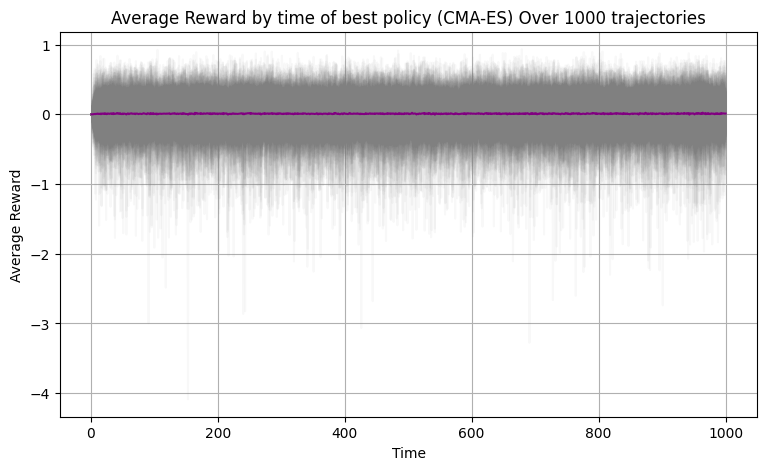

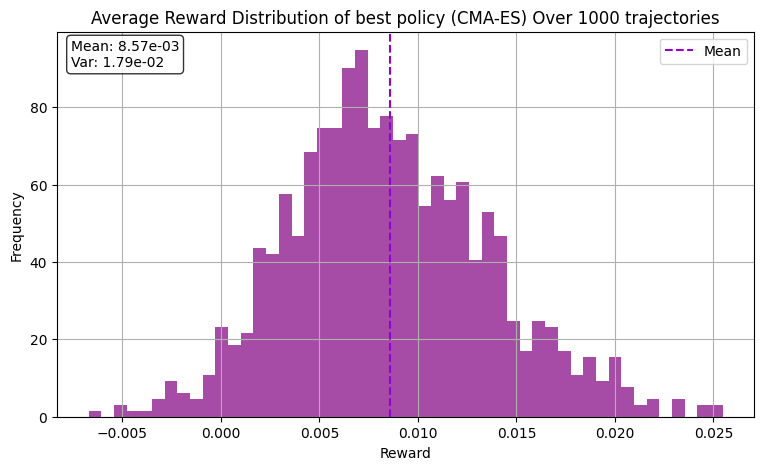

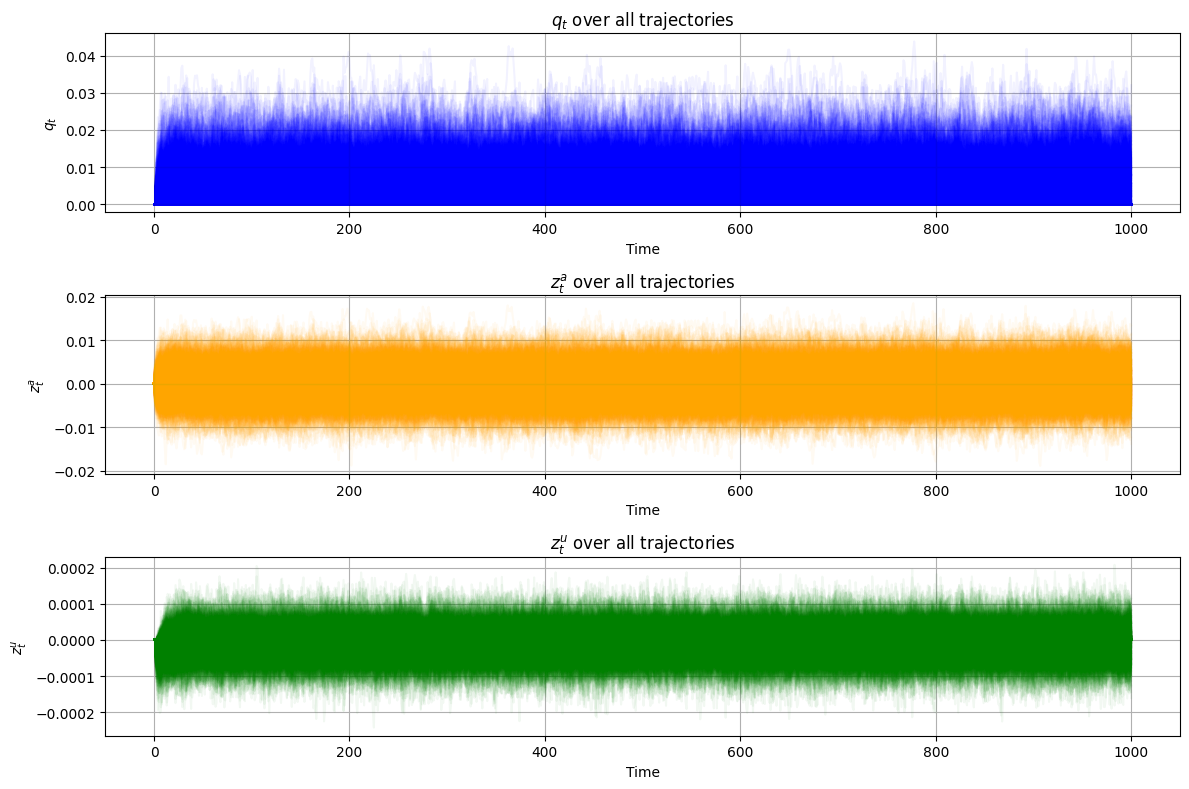

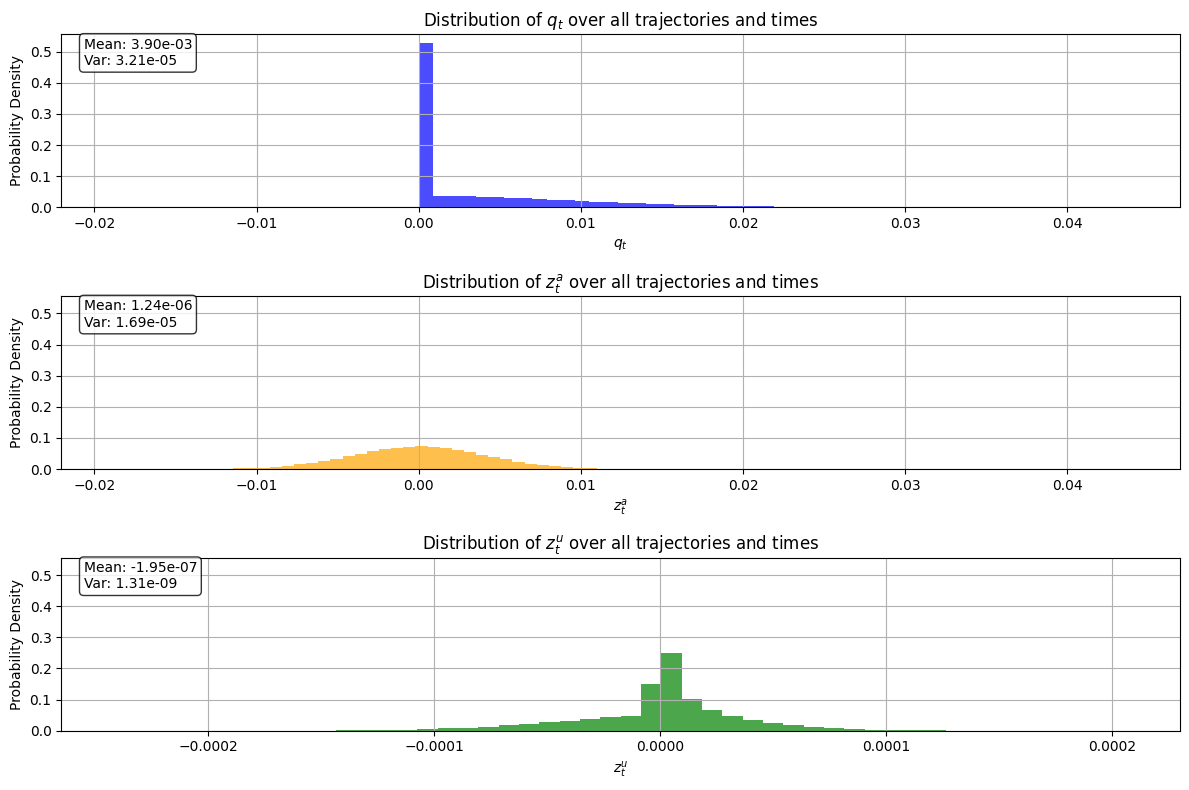

In [11]:
# print(f"best params (CMA-ES): {best_params_cma}")
# best_policy_cma = get_linear_policy(best_params_cma)
run_trajectories(best_policy_cma, N=1000, name="best policy (CMA-ES)", show_all=True)

# run_trajectories(best_policy_cma_quadratic, N=1000, name="best quadratic policy (CMA-ES)", show_all=True)

In [12]:

x, u, xi_p = generate_trajectories(best_params_cma_quadratic, x0=(0, 0, 0), T=1000)
plot_trajectories(x, u, xi_p, filename="question_3_1_1_clipped")
plot_average_reward(x, u, xi_p, filename="question_3_1_1_clipped")

NameError: name 'best_params_cma_quadratic' is not defined

# Question 4.4 

K_opt : [[ 1.11182191 -2.64863317 -2.52792524]]  residual norm: 5.4606211020642276e-11
Average approximate reward J: 0.019355062306099072
Stable: True
Average reward of LQR Optimal Policy over 100 trajectories: 0.016885415525934713 and std: 0.18859090823582678


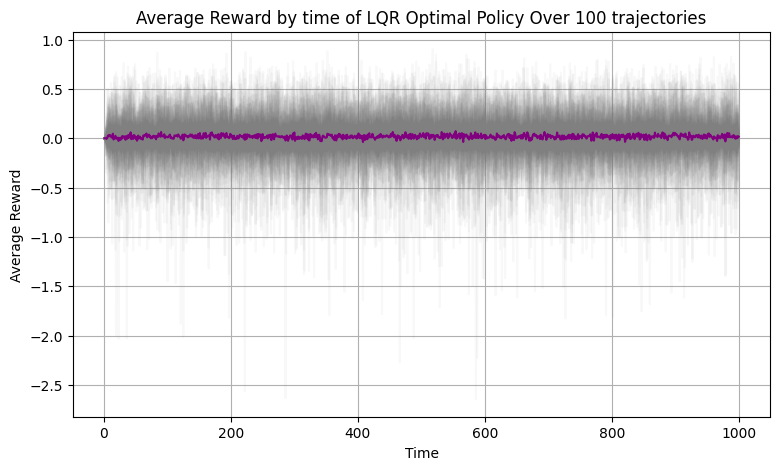

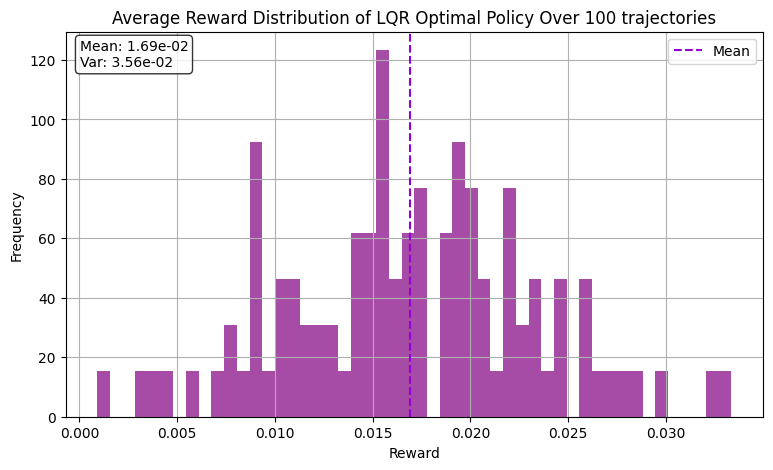

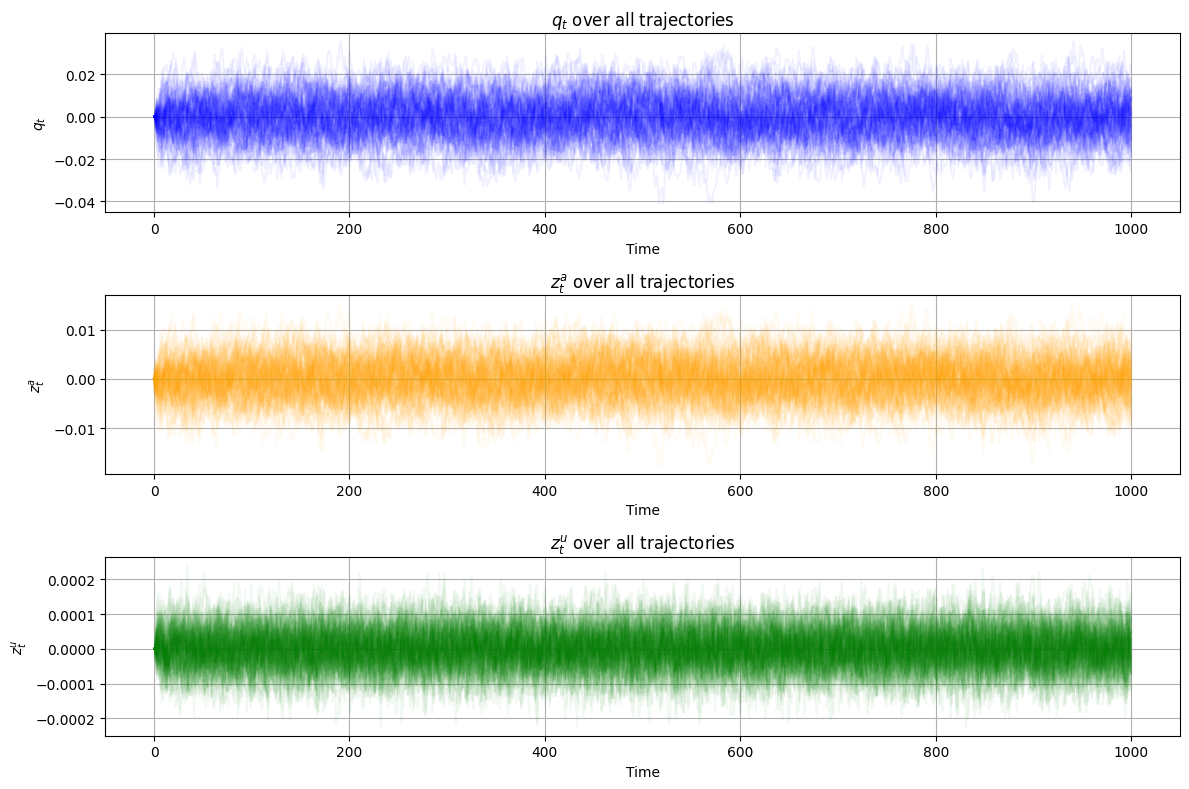

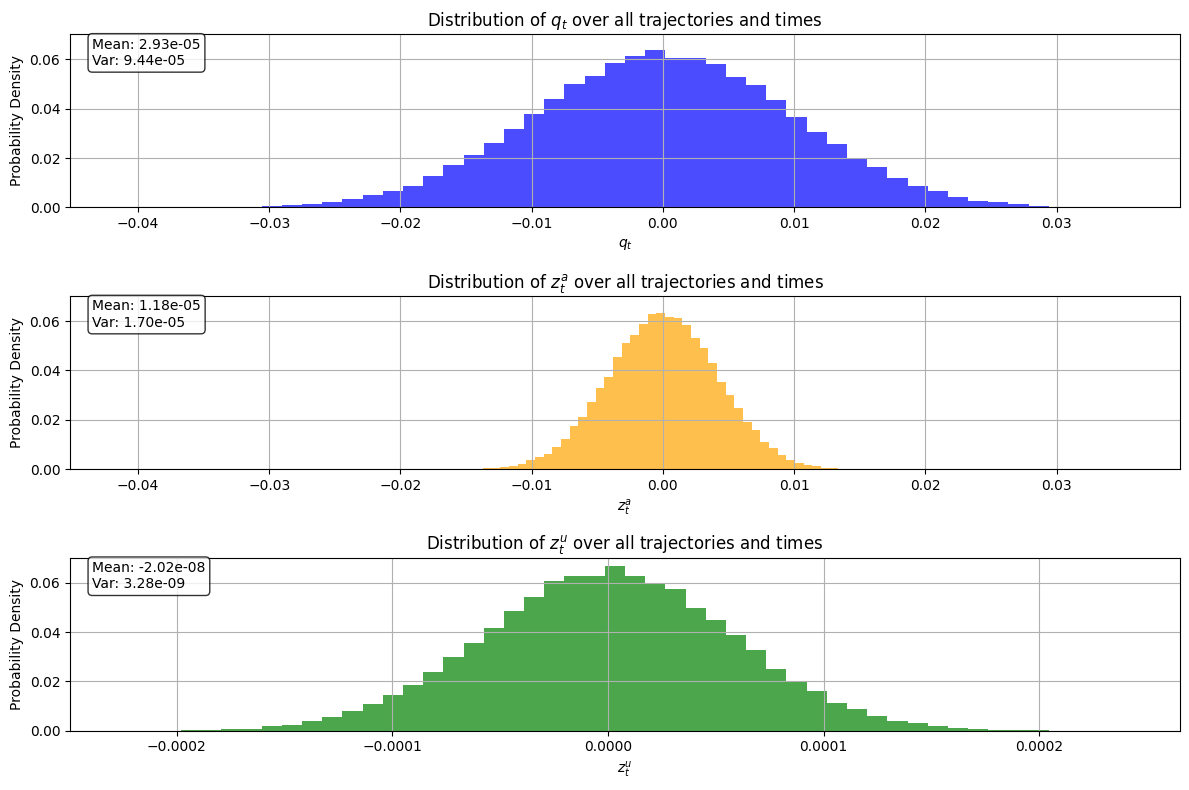

Average reward of LQR Clip Policy over 100 trajectories: 0.008356996390066757 and std: 0.13309577014834284


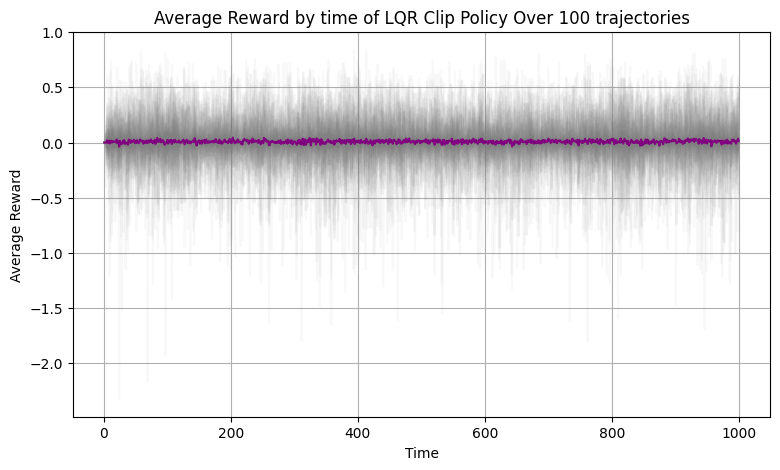

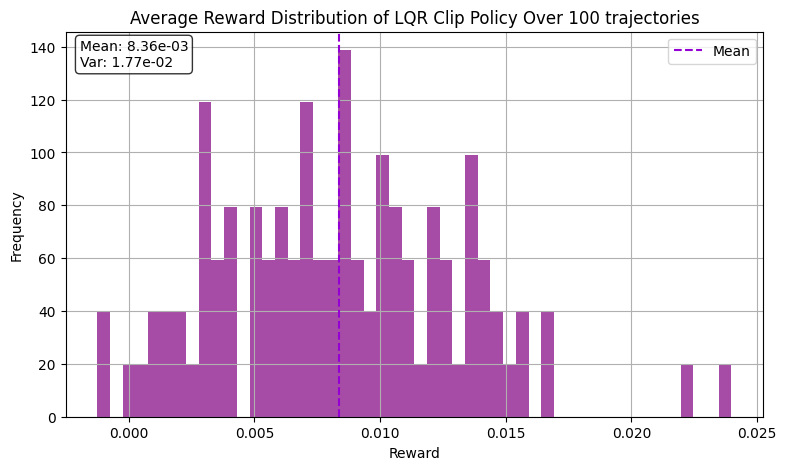

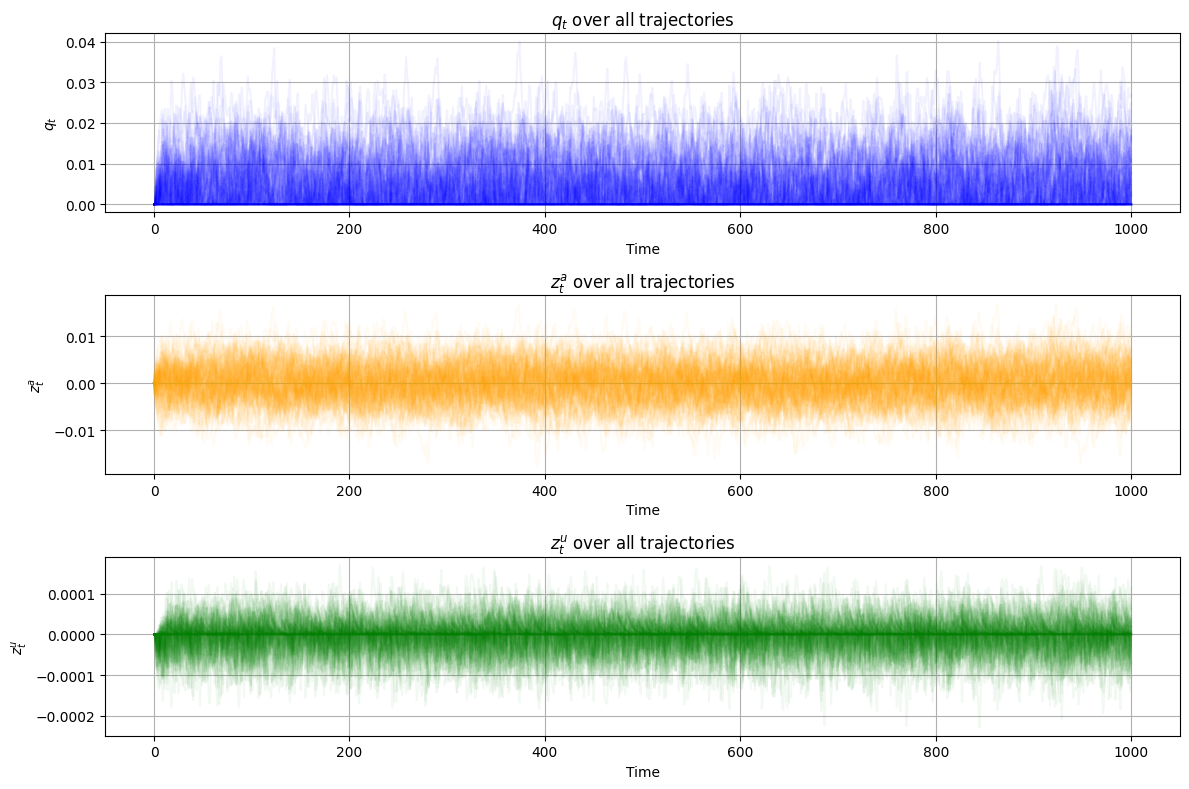

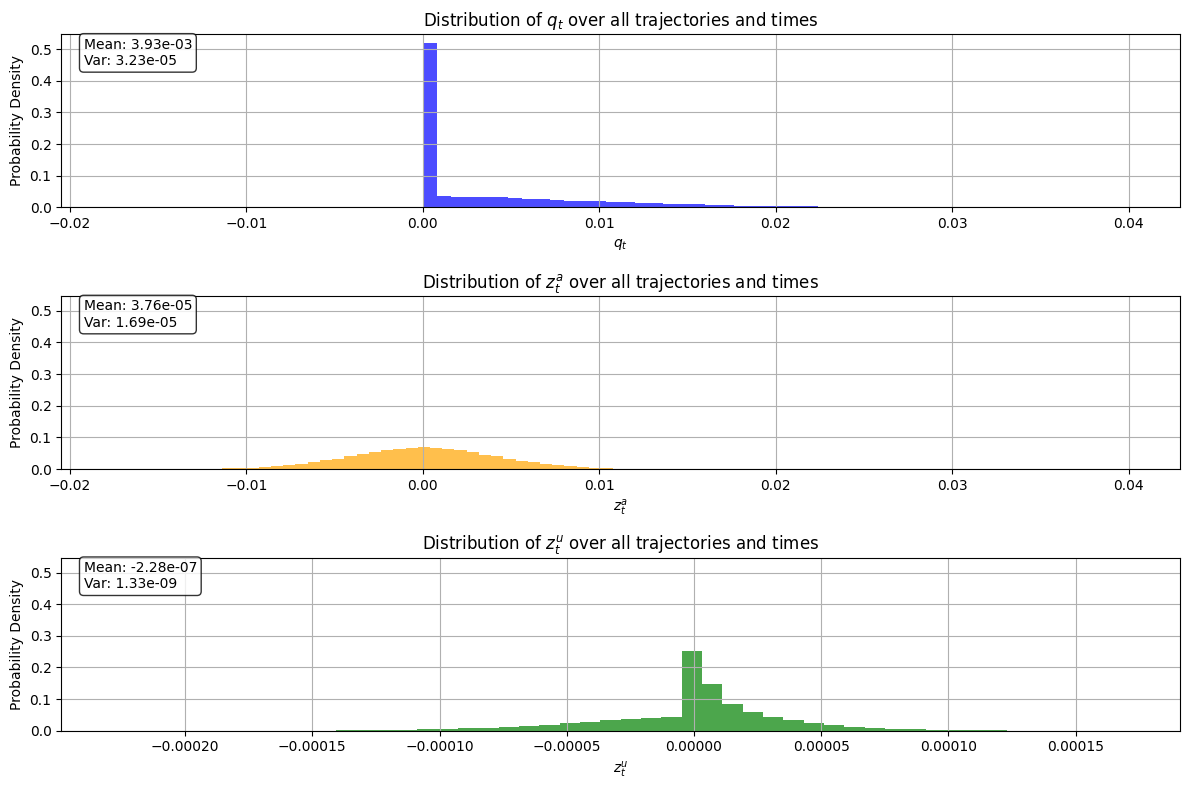

In [13]:
np.random.seed(42)


from scipy.linalg import solve_discrete_are

# def c(g):
#     """Compute the net stage reward given gross stage reward g_t for each time t"""
#     # return np.maximum(g - (np.pow(g, 2) / 2), 1 - np.exp(-g))
#     return g - (np.pow(g, 2) / 2)

def solve_ricatti_infinite_horizon(A, B, Q, R, S, max_iterations=10_000, tolerance=1e-10):
    """Solve the discrete-time algebraic Riccati equation for infinite horizon LQR.
    """
    # Initialize with Q (not zero) for better convergence
    P = Q.copy()
    for i in range(max_iterations):
        # CORRECT Riccati iteration for MINIMIZATION problem
        P_next = Q + A.T @ P @ A - (A.T @ P @ B + S) @ np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A + S.T)

        if np.abs(np.max(P - P_next)) < tolerance:
            print(f"Converged after {i+1} iterations")
            break
        P = P_next
    else:
        print("Warning: Riccati iteration did not converge")
    
    return P

def optimal_gain(A, B, Q, R, S, M):
    K = np.linalg.inv(R + B.T @ M @ B) @ (B.T @ M @ A + S.T)
    return K

# Define system matrices based on the problem description
F = np.array([[1, 0, 0], 
              [0, 1 - W_A, 0], 
              [0, 0, 1 - W_U]])

G = np.array([[1], 
              [0], 
              [W_U * BETA_U]])

D = np.array([[0, 0], [W_A * SIGMA_A, 0], [0, 0]])  # Disturbance matrix
  
# maximise r = 0.5 x.T Q x + 0.5 u.T R u + x.T N u
# minimise E(sum(-r))
# given    x_t+1 = F x_t + G u_t + D xi_t

Q = np.array([[-(1000 * SIGMA_P)**2, 1000, 1000], 
                     [1000, 0, 0], 
                     [1000, 0, 0]]) 

R = - (1000 * THETA * SIGMA_P)**2

P = np.array([[1000*GAMMA_U - THETA * ((1000 * SIGMA_P)**2)], 
                     [1000 * THETA], 
                     [1000 * THETA]]) 

# min x.T Q x + u.T R u + 2 x.T S u
Q = -0.5 * Q
R = -0.5 * R
S = -0.5 * P

R = np.array([[R]], dtype=float)             # make it (1x1) PD


# M = solve_ricatti_infinite_horizon(F, G, Q, R, S)
# K_opt = optimal_gain(F, G, Q, R, S, M)

M = solve_discrete_are(F, G, Q, R, e=np.eye(3), s=S)
K_opt = np.linalg.solve(R + G.T @ M @ G, (G.T @ M @ F + (1*S).T))

residual = F.T @ M @ F - (F.T @ M @ G + S) @ np.linalg.inv(R + G.T @ M @ G) @ (G.T @ M @ F + S.T) + Q - M
print(f"K_opt : {K_opt}  residual norm: {np.linalg.norm(residual, ord='fro')}")



K_opt = - np.array([[-0.8864, 2.1253, 1.2096]])


# Compute average approximate reward
J = - np.linalg.trace(M @ D @ D.T)
print("Average approximate reward J:", J)


def lqr_policy(x):
    u = -K_opt @ x
    return u

def lqr_clip_policy(x):
    return np.clip(lqr_policy(x), -x[0], 1 - x[0])


# Check closed-loop stability
F_cl = F - G @ K_opt
eigenvalues = np.linalg.eigvals(F_cl)
print("Stable:", all(np.abs(eigenvalues) < 1))


print("=" * 50)
# x, u, xi_p = generate_trajectories(lqr_policy, x0=(0, 0, 0), T=1000, N=1000)
# x, u, xi_p = generate_trajectories(lqr_clip_policy, x0=(0, 0, 0), T=1000, N=1000)


# x, u, xi_p = generate_trajectories(lqr_policy, x0=(0, 0, 0), T=1000, N=10, xi_p=np.zeros((1000, 10)))
# plot_average_reward(x, u, xi_p, filename="lqr_optimal_policy")
# plot_trajectories(x, u, xi_p, filename="lqr_optimal_policy")


# print(f"LQR Optimal Policy Average Reward: {average_reward(x, u, xi_p, 1000)}")
# # plot_trajectories(x, u, xi_p, T=1000)
# # plot_average_reward(x, u, xi_p, filename="lqr_optimal_policy")
run_trajectories(lqr_policy, N=100, T=1000, name="LQR Optimal Policy", show_all=True)

run_trajectories(lqr_clip_policy, N=100, T=1000, name="LQR Clip Policy", show_all=True)


policy_list.append((lqr_policy, "LQR Optimal Policy"))
policy_list.append((lqr_clip_policy, "LQR Clip Policy"))

In [ ]:
### MPC
from scipy.optimize import minimize
from scipy.linalg import block_diag


S = 10  # MPC length of the prediction horizon

q = None
# z = FF x(t) + GG q
# w = HH z + EE q


def remove_none_rows(G_hat, W_hat, S_hat):
    # Find indices of rows that contain NO None values across all three
    valid_rows = []
    for i in range(G_hat.shape[0]):
        if (not any(x is None for x in G_hat[i, :]) and
            not any(x is None for x in W_hat[i, :]) and
            not any(x is None for x in S_hat[i, :])):
            valid_rows.append(i)

    valid_rows = np.array(valid_rows)
    return (np.array(G_hat[valid_rows, :], dtype=float),
            np.array(W_hat[valid_rows, :], dtype=float),
            np.array(S_hat[valid_rows, :], dtype=float),)

def mpc_condensed(x0, N):

    nu = 1  # number of inputs  = 1
    nx = 3  # number of states  = 3
    ny = 3  # number of outputs = 3

    H = np.eye(ny)         # Output matrix (assuming full state observation)  # ny x nx
    E = np.zeros((ny, 1))  # Direct feedthrough (assuming none)  # ny x nu
    F = np.array([[1, 0, 0], 
                [0, 1 - W_A, 0], 
                [0, 0, 1 - W_U]])  # nx x nx

    G = np.array([[1], 
                [0], 
                [W_U * BETA_U]])  # nx x nu
    

    # FF = [F; F^2; ... F^N]
    FF = np.vstack([np.linalg.matrix_power(F, i+1) for i in range(N)])  # (nx*N) x nx

    # GG = [G, 0, ..., 0; FG, G, ..., 0; ...; F^(N-1)G, F^(N-2)G, ..., G]
    GG = np.zeros((F.shape[0] * N, G.shape[1] * N))  # (nx*N) x (nu*N)
    for i in range(N):
        for j in range(i + 1):
            GG[i*nx:(i+1)*nx, j*nu:(j+1)*nu] = np.linalg.matrix_power(F, i-j) @ G

    # HH = [H; HF; ... ;HF^N]
    HH = np.vstack([H @ np.linalg.matrix_power(F, i) for i in range(N+1)])  # (ny*(N+1)) x nx

    # EE = [E, 0, ..., 0; HG, E, ..., 0; ...; H F^(N-1)G, H F^(N-2)G, ..., E]
    EE = np.zeros((ny * (N+1), nu * (N+1)))  # (ny*N) x (nu*N)
    for i in range(N+1):
        for j in range(i + 1):
            if i == j:
                EE[i*ny:(i+1)*ny, j*nu:(j+1)*nu] = E
            else:
                EE[i*ny:(i+1)*ny, j*nu:(j+1)*nu] = H @ np.linalg.matrix_power(F, i-j-1) @ G

    # Q = None
    # R = None
    # R_0 = None

    # Q = -1/2 S
    Q = -np.array([[-((1000 * SIGMA_P)**2), 1000, 1000], 
                        [1000, 0, 0], 
                        [1000, 0, 0]])  # nx x nx

    # # N = -1/2 P
    # N = -np.array([[1000*GAMMA_U - THETA * ((1000 * SIGMA_P)**2)], 
    #                     [1000 * THETA], 
    #                     [1000 * THETA]]) 
    # hat(R) = -1/2 R 
    R = (THETA**2) * ((1000 * SIGMA_P)**2)  # scalar or (nu x nu)
    
    R_0 = Q # last stage cost  # nx x nx
    
    u_min, u_max = None, None  # scalar
    y_min = np.array([[-1], [None], [None]])  # (ny x 1)
    y_max = np.array([[0], [None], [None]])   # (ny x 1)


    # Q_BLK = block diagonal matrix of Q repeated N times except last block which is R_0
    Q_BLK = block_diag(*([Q] * (N - 1) + [R_0]))  # (nx*N) x (nx*N)
    R_BLK = block_diag(*([R] * N))  # (nu*N) x (nu*N)


    # min 0.5 q.T @ H_hat @ q + x(t0).T @ F_hat @ q
    F_hat = 2 * FF.T @ Q_BLK @ GG  # nx x (nu*N)
    H_hat = 2 * GG.T @ Q_BLK @ GG + R_BLK  # (nu*N) x (nu*N)

    # G_hat @ q <= W_hat + S_hat @ x0
    # G_hat = [I, -I, HG+E,-HG-E].T
    G_hat = np.vstack([np.eye(nu * N), -np.eye(nu * N), HH @ GG + EE, -HH @ GG - EE])  # (2*N + 2*ny*(N+1)) x (nu*N)
    # W_hat = [u_max , -u_min, y_max, -y_min]
    W_hat = np.vstack([u_max * np.ones((N, 1)), -u_min * np.ones((N, 1)), y_max * np.ones((ny*N, 1)), -y_min * np.ones((ny*N, 1))])  # (2*N + 2*ny*N) x 1
    # S_hat = [0, 0, -HF, HF]
    S_hat = np.vstack([np.zeros((2 * nu * N, nx)), -HH @ FF, HH @ FF ])  # (2*nu*N + 2*ny*N) x nx

    # remove if None in G_hat, W_hat, S_hat
    # rows_to_keep = 
    # rows_to_keep = np.where(np.all(G_hat != None, axis=1) & np.all(W_hat != None, axis=1) & np.all(S_hat != None, axis=1))[0]
    # G_hat = G_hat[rows_to_keep]  # (n_constraints) x (nu*N)
    # W_hat = W_hat[rows_to_keep]  # (n_constraints) x 1
    # S_hat = S_hat[rows_to_keep]  # (n_constraints) x nx

    G_hat, W_hat, S_hat = remove_none_rows(G_hat, W_hat, S_hat)

    q = np.zeros((N, 1))  # Initialize decision variable  # (nu*N) x 1


    ###### solve

    def objective(q):
        q = q.reshape(-1, 1)
        return float(0.5 * q.T @ H_hat @ q + x0.T @ F_hat @ q)

    constraints = [{'type': 'ineq', 'fun': lambda q: (W_hat + S_hat @ x0 - G_hat @ q).flatten()}]
    result = minimize(objective, q, constraints=constraints)

    if result.success:
        q = result.x
    else:
        print("Optimization failed:", result.message)

    return q


def mpc_policy(x0, N=10):
    q = mpc_condensed(x0, N)
    return q[0]


# test
run_trajectories(mpc_policy, N=100, T=100, name="MPC Optimal Policy", show_all=True)








ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 30 is different from 3)

Generating trajectories: 100%|██████████| 1000/1000 [00:41<00:00, 24.12it/s]


Average reward of MPC Optimal Policy over 1 trajectories: 0.01155636062131825 and std: 0.1529291163576365


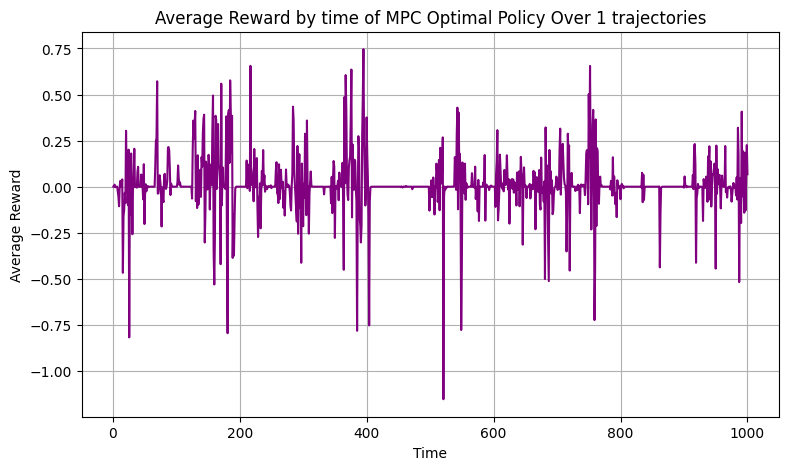

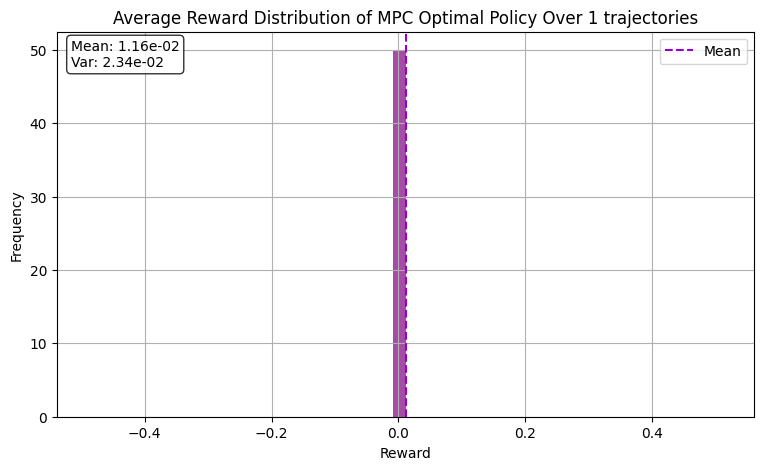

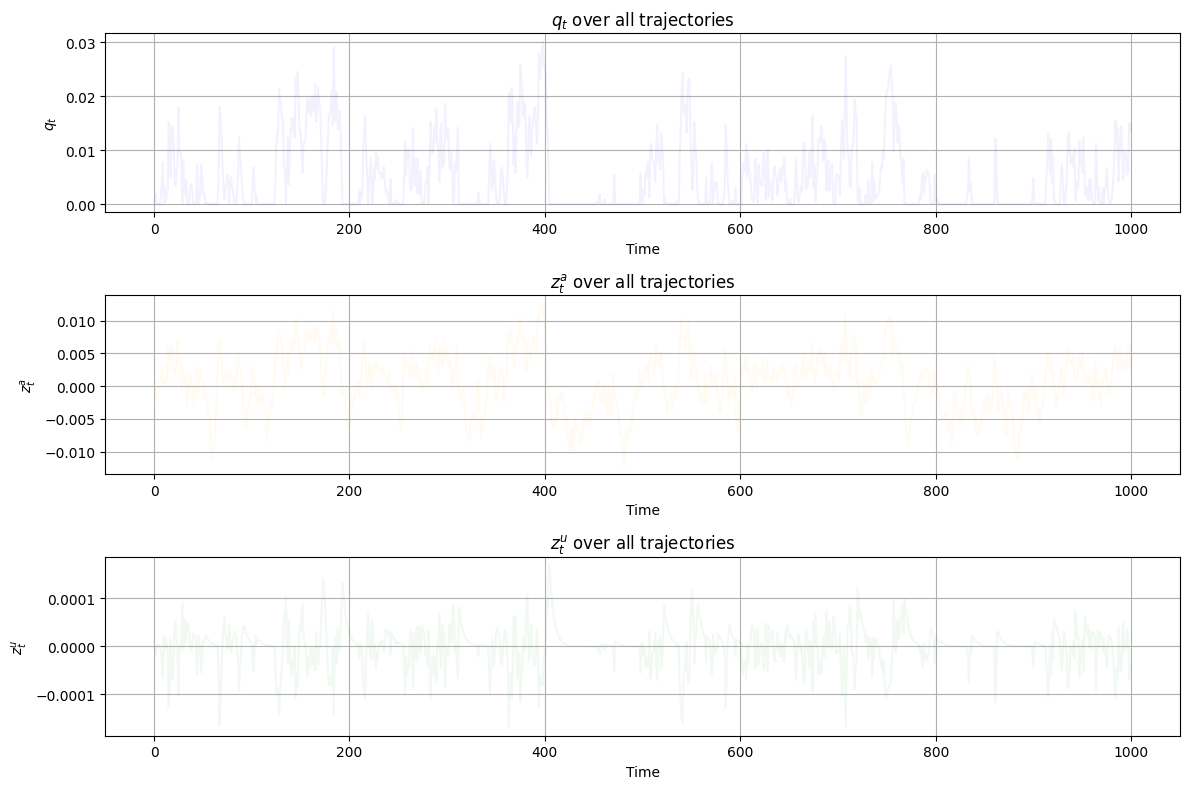

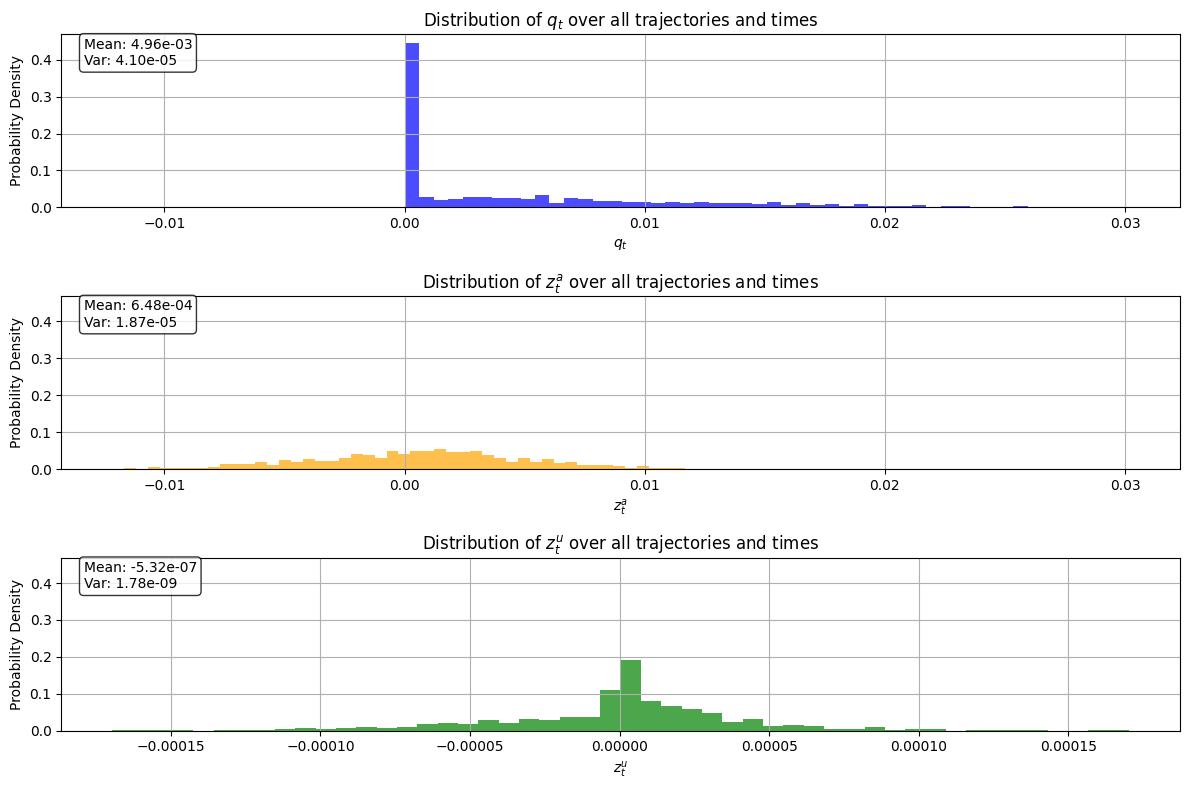

In [37]:

# %pip install cvxpy
import cvxpy as cp
from scipy.optimize import minimize, LinearConstraint, Bounds
N = 20


nu = 1  # number of inputs  = 1
nx = 3  # number of states  = 3
ny = 3  # number of outputs = 3

H = np.eye(ny)         # Output matrix (assuming full state observation)  # ny x nx
E = np.zeros((ny, 1))  # Direct feedthrough (assuming none)  # ny x nu

# we use F, G, Q, R, S from before
# min x.T Q x + u.T R u + 2 x.T S u
R_0 = Q # last stage cost  # nx x nx

u_min, u_max = [None], [None]  # scalar
y_min = np.array([0, None, None], dtype=object)  # (ny x 1)
y_max = np.array([1, None, None], dtype=object)   # (ny x 1)


# --- Symmetrize weights ---
Q, R, R_0 = map(lambda M: 0.5*(M+M.T), (Q, R, R_0))
nZ, nQ, n = (N+1)*nx, N*nu, (N+1)*nx + N*nu
z = lambda k: slice(k*nx, (k+1)*nx)
q = lambda k: slice(nZ + k*nu, nZ + (k+1)*nu)

# --- Quadratic cost matrix ---
Hobj = np.zeros((n, n))
for k in range(N):
    Hobj[z(k), z(k)] += Q
    Hobj[q(k), q(k)] += R
    Hobj[z(k), q(k)] += S
    Hobj[q(k), z(k)] += S.T
Hobj[z(N), z(N)] += R_0
Hobj = 0.5 * (Hobj + Hobj.T)
f_obj = lambda w: 0.5 * w @ (Hobj @ w)
g_obj = lambda w: Hobj @ w
hess  = lambda w: Hobj

# --- Equality constraints: z₀=x₀, dynamics ---
Aeq = np.zeros((nx*(N+1), n))
Aeq[:nx, z(0)] = np.eye(nx)
for k in range(N):
    Aeq[nx*(k+1):nx*(k+2), z(k+1)] = np.eye(nx)
    Aeq[nx*(k+1):nx*(k+2), z(k)]   = -F
    Aeq[nx*(k+1):nx*(k+2), q(k)]   = -G

# --- Output constraints ---
ymin = np.array([float(v) if v is not None else -np.inf for v in y_min])
ymax = np.array([float(v) if v is not None else  np.inf for v in y_max])
Aineq = np.zeros((N*ny, n))
lb, ub = np.tile(ymin, N), np.tile(ymax, N)
for k in range(N):
    Aineq[k*ny:(k+1)*ny, z(k)] = H
    Aineq[k*ny:(k+1)*ny, q(k)] = E


# --- Variable bounds (only q) ---
lb_w, ub_w = np.full(n, -np.inf), np.full(n, np.inf)
for k in range(N):
    for i in range(nu):
        idx = q(k).start + i
        if u_min[i] is not None: lb_w[idx] = u_min[i]
        if u_max[i] is not None: ub_w[idx] = u_max[i]


def solve_mpc(x0, N):
    x0 = np.asarray(x0, dtype=float).reshape(-1)

    beq = np.zeros(nx*(N+1))
    beq[:nx] = x0
    lin_eq = LinearConstraint(Aeq, beq, beq)
    lin_ineq = LinearConstraint(Aineq, lb, ub)
    bounds = Bounds(lb_w, ub_w)

    # --- Initial guess ---
    w0 = np.zeros(n)
    w0[z(0)] = x0

    # --- Solve ---
    res = minimize(f_obj, w0, method="trust-constr", jac=g_obj, hess=hess,
                   constraints=[lin_eq, lin_ineq], bounds=bounds,
                   options=dict(maxiter=1000, gtol=1e-8, verbose=0))
    if not res.success:
        raise RuntimeError(f"MPC solve failed: {res.message}")
    return res.x[q(0)].reshape(nu)





##############################################

# F_stack = np.zeros(((N+1)*nx, nx))
# G_stack = np.zeros(((N+1)*nx, N*nu))
# for k in range(N+1):
#     F_stack[k*nx:(k+1)*nx, :] = np.linalg.matrix_power(F, k)
#     for j in range(k):
#         G_stack[k*nx:(k+1)*nx, j*nu:(j+1)*nu] = np.linalg.matrix_power(F, k-1-j) @ G

# # Full Q block including terminal cost
# Qblk_full = np.kron(np.eye(N+1), Q)
# Qblk_full[-nx:, -nx:] = R_0

# # Condensed Hessian and gradient
# Hc = G_stack.T @ Qblk_full @ G_stack + np.kron(np.eye(N), R)


# # Optional: include cross term S if needed
# # Hc += (G_stack.T @ np.kron(np.eye(N+1, N), S) @ G_stack)
# # fc += (x0.T @ ... )  # omit if S = 0 or small

# # Input bounds
# lb = np.full(N*nu, -np.inf)
# ub = np.full(N*nu,  np.inf)
# for i in range(nu):
#     if u_min[i] is not None:
#         lb[i::nu] = float(u_min[i])
#     if u_max[i] is not None:
#         ub[i::nu] = float(u_max[i])

# FQG_stack = F_stack.T @ Qblk_full @ G_stack

def solve_mpc_fast(x0, N): 
    # fc = (F_stack @ x0).T @ Qblk_full @ G_stack
    # fc = x0.T @ F_stack.T @ Qblk_full @ G_stack
    fc = x0.T @ FQG_stack

    bounds = Bounds(lb, ub)

    def obj(q):
        return 0.5 * q @ (Hc @ q) + fc @ q
    def grad(q):
        return Hc @ q + fc

    # Solve box-constrained QP (fast)
    res = minimize(obj, np.zeros(N*nu), jac=grad, bounds=bounds,
                   method="L-BFGS-B", options=dict(maxiter=200, ftol=1e-9, disp=False))

    if not res.success:
        raise RuntimeError(f"MPC condensed QP did not solve: {res.message}")

    q0 = res.x[:nu]
    return np.asarray(q0).reshape(nu)

# def solve_mpc(x0, N, nu, nx, ny, F, G, H, E, Q, R, S, R_0,
#               u_min, u_max, y_min, y_max):
#     ###### solve
#     # min z.T @ R_0 @ z + sum (z.T @ Q @ z + q.T @ R @ q + z.T @ S @ u)
#     # z_0 = x(t)
#     # z_k+1 = F z_k + G q_k
#     # w_k = H z_k + E q_k
#     # u_min <= q_k <= u_max
#     # y_min <= w_k <= y_max

#     P = np.block([[Q,  S],
#                   [S.T, R]])

#     # Symmetrize weights (numerical safety)
#     Q  = 0.5 * (Q + Q.T)
#     R  = 0.5 * (R + R.T)
#     R_0 = 0.5 * (R_0 + R_0.T)
#     P  = 0.5 * (P + P.T)

#         # Require R ≻ 0 (needed for the completion)
#     # If R is scalar, promote; otherwise check PD
#     try:
#         R_inv = np.linalg.inv(R)
#     except np.linalg.LinAlgError:
#         raise ValueError("R must be positive definite (invertible) for the cross-term rewrite.")

#     # ---- CVXPY variables ----
#     z = [cp.Variable(nx) for _ in range(N + 1)]
#     q = [cp.Variable(nu) for _ in range(N)]

#     constraints = [z[0] == np.asarray(x0, dtype=float).reshape(nx)]

#     # objective = cp.quad_form(z[N], R_0)
#     objective = 0

#     for k in range(N):
#         # cost = z[k].T @ Q @ z[k] + q[k].T @ R @ q[k] + 2 * z[k].T @ S @ q[k]
#         # objective += cp.quad_form(z[k], Q) + cp.quad_form(q[k], R) + 2 * cp.quad_form(z[k], S @ q[k])
#         v_k = cp.hstack([z[k], q[k]])            # length nx + nu
#         objective += cp.quad_form(v_k, P)

#         # dynamics
#         constraints += [z[k + 1] == F @ z[k] + G @ q[k]]
        
#         # input bounds
#         for i in range(nu):
#             if u_min[i] is not None: constraints += [q[k][i] >= float(u_min[i])]
#             if u_max[i] is not None: constraints += [q[k][i] <= float(u_max[i])]
#         # output bounds
#         w_k = H @ z[k] + E @ q[k]
#         for i in range(ny):
#             if y_min[i] is not None: constraints += [w_k[i] >= float(y_min[i])]
#             if y_max[i] is not None: constraints += [w_k[i] <= float(y_max[i])]

#     prob = cp.Problem(cp.Minimize(objective), constraints)

#     # Prefer OSQP for QPs; fall back to default if unavailable.
#     # try:
#     #     prob.solve(solver=cp.OSQP, warm_start=True, eps_abs=1e-6, eps_rel=1e-6, max_iter=20000)
#     #     # Problem does not follow DCP rules. Use other solver.
#     # except Exception:
#     #     prob.solve(warm_start=True)


#     # Try nonconvex-compatible solvers
#     solved = False
#     for solver in [cp.GUROBI, cp.CPLEX, cp.MOSEK, cp.SCIPY]:
#         try:
#             prob.solve(solver=solver, warm_start=True, verbose=False, 
#             solved = prob.status in ("optimal", "optimal_inaccurate")
#             if solved:
#                 print(f"✅ Solved with {solver}")
#                 break
#         except Exception as e:
#             print(f"⚠️ Solver {solver} failed: {e}")
#             continue


#     if not solved:
#         raise RuntimeError(f"MPC QP did not solve: status={prob.status}")

#     if prob.status not in ("optimal", "optimal_inaccurate"):
#         raise RuntimeError(f"MPC QP did not solve: status={prob.status}")

#     q0 = q[0].value
#     return np.asarray(q0, dtype=float).reshape(nu)


def mpc_policy(x0, N=N):
    q = solve_mpc(x0, N)
    # print("MPC control action:", q[0])
    return q[0]


# test
run_trajectories(mpc_policy, N=1, T=1000, name="MPC Optimal Policy", show_all=True, show_progress=True)





Evaluation of all policies over 10000 trajectories ...
Initial Policy                  Average reward = 0.01065726 , Std = 0.00295488
Clipped Initial Policy          Average reward = 0.00536819 , Std = 0.00231497
Best linear Policy (CMA-ES)     Average reward = 0.00835463 , Std = 0.00485641
LQR Optimal Policy              Average reward = 0.01673995 , Std = 0.00654801
LQR Clip Policy                 Average reward = 0.00835087 , Std = 0.00488157


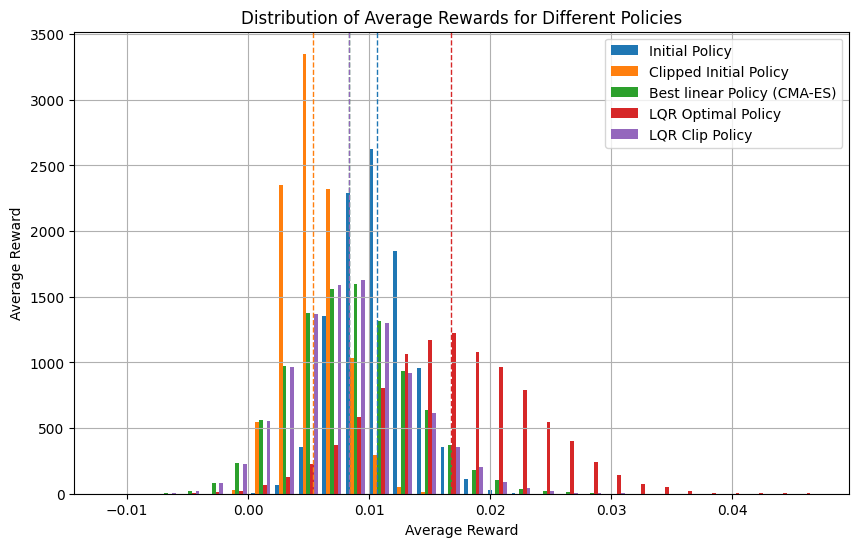

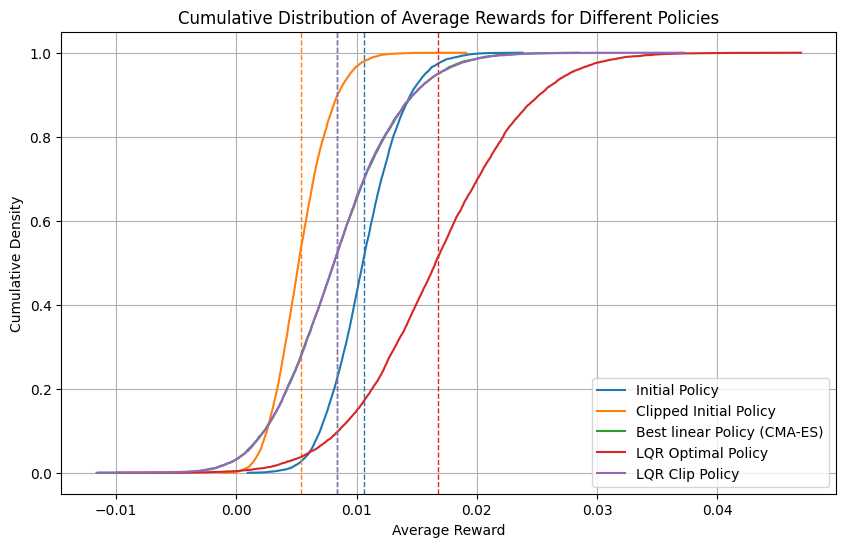

In [ ]:
# run for all 3 policies and store the rewards
S = 10000

print(f"Evaluation of all policies over {S} trajectories ...")
# filter out duplicate policies by name
policy_list = list({name: (func, name) for func, name in policy_list}.values())

all_rewards = np.zeros((len(policy_list), S))
for i in range(len(policy_list)):
    x, u, xi_p = generate_trajectories(policy_list[i][0], x0=(0, 0, 0), T=1000, N=S)
    all_rewards[i] = np.nanmean(reward(x, u, xi_p, 1000), axis=0).T
    print(f"{policy_list[i][1]:30s}  Average reward = {np.nanmean(all_rewards[i]):.8f} , Std = {np.std(all_rewards[i]):.8f}")


# plot all the rewards
plt.figure(figsize=(10, 6))
labels = [policy_list[i][1] for i in range(len(policy_list))]
plt.hist(all_rewards.T, bins=30, label=labels, alpha=1)
# add the mean of each distribution
for i in range(all_rewards.shape[0]):
    plt.axvline(np.nanmean(all_rewards[i]), color=f'C{i}', linestyle='dashed', linewidth=1)
plt.xlabel('Average Reward')

plt.title('Distribution of Average Rewards for Different Policies')
plt.ylabel('Average Reward')
plt.grid()
plt.legend()
plt.show()

# the integral plot
plt.figure(figsize=(10, 6))
for i in range(all_rewards.shape[0]):
    sorted_rewards = np.sort(all_rewards[i])
    cumulative = np.arange(1, len(sorted_rewards) + 1) / len(sorted_rewards)
    plt.plot(sorted_rewards, cumulative, label=labels[i])
    plt.axvline(np.nanmean(all_rewards[i]), color=f'C{i}', linestyle='dashed', linewidth=1)

plt.xlabel('Average Reward')
plt.title('Cumulative Distribution of Average Rewards for Different Policies')
plt.ylabel('Cumulative Density')
plt.grid()
plt.legend()
plt.show()

In [ ]:
test_policy